In [34]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

### Hyperparameters

In [29]:
# the number of objects in each world
WORLD_SIZE = 5

# the dimension of the feature vector of each object
# as produced by the encoder
OBJECT_FEATURE_DIMENSION = 6

# the dimension of the speaker's generated vector representation
NEURALESE_DIMENSION = 12

### Model Components

In [3]:
class ObjectEncoder(nn.Module):
    """
    Encodes a single (3x3) Object into a feature vector
    Input     : [[001][100][010]] or Purple-Cirle-No-Outline. See metadata.json
    InputSize : (3,3)
    OutputSize: (OBJECT_FEATURE_DIMENSION)
    """
    def __init__(self, output_dimension=OBJECT_FEATURE_DIMENSION):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2),  # → (batch, 4, 2, 2)
            nn.Flatten(),                    # → (batch, 16)
            nn.Linear(16, output_dimension)
        )
        
    def forward(self, x):
        return self.encoder(x)

In [4]:
class Speaker(nn.Module):
    """
    Transforms the encoded objects in world W + boolean inclusion mask for target subset X 
    into a representative vector
    
    InputSize : (WORLD_SIZE * OBJECT_FEATURE_DIMENSION) + WORLD_SIZE)
    OutputSize: (NEURALESE_DIMENSION)
    """
    def __init__(self, input_dimension=(WORLD_SIZE * OBJECT_FEATURE_DIMENSION) + WORLD_SIZE, 
                 output_dimension=NEURALESE_DIMENSION):
        super().__init__()
        self.speaker_net = nn.Sequential(
            nn.Linear(input_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dimension)
        )
    
    def forward(self, x):
        return self.speaker_net(x)

In [5]:
class Listener(nn.Module):
    """
    Takes the resultant vector from the speaker, along with W_i (an element of the world W)
    and predicts whether this element belongs to X, the target subset.
    
    InputSize : (NEURALESE_DIMENSION + OBJECT_FEATURE_DIMENSION)
    OutputSize: (1) -> logit for binary classification
    """
    def __init__(self, input_dimension=NEURALESE_DIMENSION + OBJECT_FEATURE_DIMENSION, 
                 output_dimension=1):
        super().__init__()
        self.listener_net = nn.Sequential(
            nn.Linear(input_dimension, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, output_dimension)
        )
            
    def forward(self, x):
        return self.listener_net(x)
            

In [6]:
class SpeakerListenerSystem(nn.Module):
    """
    The end-to-end system.
    Encoder -> Speaker -> Listener
    """
    def __init__(self, world_size, feature_dimension, neuralese_dimension):
        super().__init__()
        
        self.world_size          = world_size
        self.feature_dimension   = feature_dimension
        self.neuralese_dimension = neuralese_dimension
        
        speaker_input_size  = (self.world_size * self.feature_dimension) + self.world_size
        listener_input_size = self.neuralese_dimension + self.feature_dimension
        
        self.encoder  = ObjectEncoder(output_dimension=self.feature_dimension)
        self.speaker  = Speaker(input_dimension=speaker_input_size, output_dimension=neuralese_dimension)
        self.listener = Listener(input_dimension=listener_input_size, output_dimension=1)
        
        
    def forward(self, W, X_mask, return_neuralese_only=False):
        """
        W:      A batch of worlds. 
                Each world is a set of (3x3) objects.
                Tensor of shape (batch_size, world_size, 3, 3).
                
        X_mask: A batch of boolean masks
                Each value indicated whether the object at that index in W
                is included in the target subset X
                Tensor of shape (batch_size, world_size)
        """
        batch_size = W.shape[0]
        
        ### STEP 1: Encode all objects in the world
        # Reshape for batch processing ny the encoder (B, 5, 3, 3) -> (B*5, 1, 3, 3)
        W_flat = W.view(-1, 1, 3, 3)
        # Get features for all objects: (B*5, feature_dim)
        object_features_flat = self.encoder(W_flat)
        # Reshape back to per-batch item:(B, 5, feature_dim)
        object_features = object_features_flat.view(batch_size, self.world_size, self.feature_dimension)
        
        
        ### STEP 2: Assemble the inputs to the speaker model
        # Flatten object features: (B, 5, feature_dim) -> (B, 5*feature_dim)
        V_W =  object_features.view(batch_size, -1)
        # Create the indicator mask
        M_X = X_mask
        # Concatenate features and mask
        speaker_input = torch.cat([V_W, M_X], dim=1)
        
        
        ### STEP 3: Speaker generates neuralese
        # representation has shape (B, neuralese_dimension)
        representation = self.speaker(speaker_input)

        if return_neuralese_only:
            return representation
        
        ### STEP 4: Prepare the listener's input
        # The listener needs to pair the speaker's representation with each object feature
        # Expand the representation to match the number of objects
        # (B, rep_dim) -> (B, 1, rep_dim) -> (B, world_size, rep_dim)
        r_expanded = representation.unsqueeze(1).repeat(1, self.world_size, 1)
        # Concatenate with object features: (B, 5, rep_dim) + (B, 5, feature_dim)
        listener_input = torch.cat([r_expanded, object_features], dim=2)
        
        
        ### STEP 5: Shuffle inputs to the listener
        # This is to avoid the speaker simply learning to tell the listener about X_mask
        # without learning anything about the objects in X themselves.
        # Create a random permutation for each item in the batch
        shuffled_indices = [torch.randperm(self.world_size) for _ in range(batch_size)]
        # Apply the shuffle
        shuffled_input   = torch.stack([features[p] for features, p in zip(listener_input, shuffled_indices)])
        shuffled_labels  = torch.stack([labels[p]   for labels,   p in zip(X_mask, shuffled_indices)])
        
        
        ### STEP 6: Listener makes an inclusion prediction for each object
        # Reshape for batch processing by the listener
        # (B, 5, rep_dim + feature_dim) -> (B*5, rep_dim + feature_dim)
        listener_input_flat = shuffled_input.view(-1, self.neuralese_dimension + self.feature_dimension)
        # Get predictions (logits) -> (B*5, 1)
        predictions_flat = self.listener(listener_input_flat)
        # Reshape back to (B, world_size)
        predictions = predictions_flat.view(batch_size, self.world_size)
        
        return predictions, shuffled_labels

In [30]:
class Translator(nn.Module):
    """
    Translates neuralese representation V into natural language rule R.

    Takes the learned communication vector V (produced by the speaker) and 
    predicts the original rule R as a fixed-length sequence of tokens.
    Each position in the sequence is predicted independently via classification 
    over the vocabulary (features, logical operators, and blank token).
    """
    def __init__(self, neuralese_dimension=NEURALESE_DIMENSION, 
                 max_rule_length=3, vocab_size=13, hidden_dimension=128):
        super().__init__() 
        self.max_rule_length     = max_rule_length
        self.neuralese_dimension = neuralese_dimension
        self.vocab_size          = vocab_size

        self.translation_net = nn.Sequential(
        nn.Linear(neuralese_dimension, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, max_rule_length * vocab_size)
        )
            
        
    def forward(self, V):
        """
        Arguments:
        V : A batch of neuralese representations (batch_size,  neuralese_dimension)

        Returns:
        logits : (batch_size, max_rule_length, vocab_size)
        """
        batch_size = V.shape[0]

        output = self.translation_net(V)  # (batch_size, max_rule_length * vocab_size)
        logits = output.view(batch_size, self.max_rule_length, self.vocab_size)

        return logits
    
# Alternative architectures to consider:

# Autoregressive (if you want token dependencies):
# Use an RNN/LSTM that generates one token at a time
# token_1 depends only on V
# token_2 depends on V and token_1, etc.

# Deeper MLP with position embeddings:
# Add learnable position embeddings to help the model 
# know which position it's predicting

### Data Loading

In [8]:
def generate_batch(batch_size, world_size):
    """Generates a batch of dummy data"""
    
    # Random 3x3 objects for the world
    W_batch = torch.rand(batch_size, world_size, 3, 3)
    
    # Random binary masks
    X_mask_batch = torch.randint(0, 2, (batch_size, world_size)).float()
    
    # Ensure at least one object is selected in each world
    for i in range(batch_size):
        if X_mask_batch[i].sum() == 0:
            # Randomly select one object
            X_mask_batch[i, random.randint(0, world_size-1)] = 1.0
    
    
    return W_batch, X_mask_batch

In [9]:
def load_dataset(path='dataset.npz'):
    """Load the real dataset from npz file"""
    
    data = np.load(path, allow_pickle=True)
    
    W = data['W']
    X_mask = data['X_mask']
    rule_encodings = data['rule_encodings']
    rule_texts = data['rule_texts']
    
    # Load metadata
    metadata_path = path.replace('.npz', '_metadata.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    return W, X_mask, rule_encodings, rule_texts, metadata

In [10]:
def split_dataset(W, X_mask, rule_encodings, rule_texts, 
                speaker_listener_ratio=0.5,
                translator_train_ratio=0.4,
                translator_test_ratio =0.1,
                seed=42):
    
    """
    Split dataset into three portions with shuffling:
    1. Speaker-Listener training (50%)
    2. Translator training (40%)
    3. Translator testing (10%)
    
    Args:
        W: World matrices [N, 5, 3, 3]
        X_mask: Subset masks [N, 5]
        rule_encodings: Rule encodings [N, ...]
        rule_texts: Rule text strings [N]
        speaker_listener_ratio: Fraction for speaker-listener
        translator_train_ratio: Fraction for translator training
        translator_test_ratio: Fraction for translator testing
        seed: Random seed for reproducibility
    
    Returns:
        Dictionary with all splits
    """
    
    assert abs(speaker_listener_ratio + translator_train_ratio + translator_test_ratio - 1.0) < 1e-6, \
           "Ratios must sum to 1.0"
    np.random.seed(seed)

    # Shuffle the dataset
    N_total = len(W)
    indices = np.random.permutation(N_total)

    # Calculate sizes of data portions
    speaker_listener_size = int(N_total * speaker_listener_ratio)
    translator_train_size = int(N_total * translator_train_ratio)
    translator_test_size  = int(N_total * translator_test_ratio)

    # Calculate indices for splitting
    speaker_listener_idx = indices[:speaker_listener_size]
    translator_train_idx = indices[speaker_listener_size:speaker_listener_size + translator_train_size]
    translator_test_idx  = indices[speaker_listener_size + translator_train_size:]

    # Split the data
    split_dataset = {
        'speaker_listener': {
            'W':              torch.tensor(W[speaker_listener_idx]).float(),
            'X_mask':         torch.tensor(X_mask[speaker_listener_idx]).float(),
            'rule_encodings': rule_encodings[speaker_listener_idx],
            'rule_texts':     rule_texts[speaker_listener_idx]
        },
        'translator_train': {
            'W':              torch.tensor(W[translator_train_idx]).float(),
            'X_mask':         torch.tensor(X_mask[translator_train_idx]).float(),
            'rule_encodings': rule_encodings[translator_train_idx],
            'rule_texts':     rule_texts[translator_train_idx]
        },
        'translator_test': {
            'W':              torch.tensor(W[translator_test_idx]).float(),
            'X_mask':         torch.tensor(X_mask[translator_test_idx]).float(),
            'rule_encodings': rule_encodings[translator_test_idx],
            'rule_texts':     rule_texts[translator_test_idx]
        }
    }

    print("Dataset Split:")
    print(f"  Speaker-Listener:  {len(speaker_listener_idx):,} ({speaker_listener_ratio*100:.0f}%)")
    print(f"  Translator Train:  {len(translator_train_idx):,} ({translator_train_ratio*100:.0f}%)")
    print(f"  Translator Test:   {len(translator_test_idx):,}  ({translator_test_ratio*100:.0f}%)")
    print(f"  Total:             {N_total:,}")

    return split_dataset

In [11]:
# Load dataset and split
W_data, X_mask_data, rule_encodings_data, rule_texts_data, metadata = load_dataset('dataset.npz')
dataset_splits = split_dataset(W_data, X_mask_data, rule_encodings_data, rule_texts_data)

def load_batch(split_name, start_idx, batch_size, include_rules=False):
    """Load a batch of data from the specified split"""
    split = dataset_splits[split_name]
    end_idx = start_idx + batch_size

    Wb = split['W'][start_idx:end_idx]
    Xb = split['X_mask'][start_idx:end_idx]

    if include_rules:
        rb = split['rule_tokens'][start_idx:end_idx]
        return Wb, Xb, rb

    return Wb, Xb

Dataset Split:
  Speaker-Listener:  852,916 (50%)
  Translator Train:  682,333 (40%)
  Translator Test:   170,584  (10%)
  Total:             1,705,833


### Visualizations

In [12]:
def plot_metric(values, step_size, metric_name, save_path=None, figsize=(10,6)):
    """
    Plot training metric (loss or accuracy) over epochs

    Args:
        values: List or array of metric values recorded during training
        step_size: Number of epochs between each recorded value (e.g., 50 if you log every 50 epochs)
        metric_name: Name of the metric for labels (e.g., 'Loss', 'Accuracy')
        save_path: Optional path to save the figure (e.g., 'speaker_loss.png')
        figsize: Tuple specifying figure size (width, height)
    
    Example:
        plot_metric(losses, 50, 'Loss', save_path='speaker_loss.png')
        plot_metric(accuracies, 50, 'Accuracy', save_path='speaker_accuracy
    """
    
    # Calculate epochs based on step size
    epochs = np.arange(step_size, len(values)*step_size + 1, step_size)

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(epochs, values, linewidth=2, color="#B41F1F" if 'loss' in metric_name.lower() else "#35B457")

    # Styling 
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(f'{metric_name} over Training', fontsize=14)

    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

## The  Speaker Listener

### Training

In [ ]:
# Hyperparameters for training
BATCH_SIZE    = 32 # 32
NUM_EPOCHS    = 2  # 10
LEARNING_RATE = 1e-4

In [14]:
# Instantiate the system
model = SpeakerListenerSystem(
    world_size          = WORLD_SIZE,
    feature_dimension   = OBJECT_FEATURE_DIMENSION,
    neuralese_dimension = NEURALESE_DIMENSION,
)

# Use BCEWithLogitsLoss because our model outputs raw logits (more stable)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:

step = 0
start_index = 0
N_DATA = len(dataset_splits['speaker_listener']['W'])

losses = []
accuracies = []

print("Starting speaker-listener training...")
for epoch in range(NUM_EPOCHS):
    start_index = 0

    # Stop when we run out of data
    while start_index < N_DATA:
        batch_size = min(BATCH_SIZE, N_DATA - start_index)

        # Load a batch of speaker-listener training data
        W, X_mask = load_batch('speaker_listener', start_index, batch_size)
        start_index += BATCH_SIZE
        step += 1
        
        # Forward pass - y_truth is the shuffled X_mask
        optimizer.zero_grad()
        y_logits, y_truth = model(W, X_mask)
        
        # Calculate loss - (y_truth serves as the ground truth)
        loss = criterion(y_logits, y_truth)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        if (step + 1) % 500 == 0:
            # Track data consumption
            print(f"Epoch: {epoch}. start_index: {start_index}, end_index: {start_index + batch_size}")

            # Calculate accuracy for monitoring
            preds    = torch.sigmoid(y_logits) > 0.5
            accuracy = (preds.float() == y_truth).float().mean() 
            print(f"Step [{step+1}/---], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

            # Store metrics
            losses.append(loss.item())
            accuracies.append(accuracy.item())
        
print("Training finished.")

Starting speaker-listener training...
Epoch: 0. start_index: 15968, end_index: 16000
Step [500/---], Loss: 0.6200, Accuracy: 0.6812
Epoch: 0. start_index: 31968, end_index: 32000
Step [1000/---], Loss: 0.6040, Accuracy: 0.6812
Epoch: 0. start_index: 47968, end_index: 48000
Step [1500/---], Loss: 0.6082, Accuracy: 0.6750
Epoch: 0. start_index: 63968, end_index: 64000
Step [2000/---], Loss: 0.5916, Accuracy: 0.6938
Epoch: 0. start_index: 79968, end_index: 80000
Step [2500/---], Loss: 0.5909, Accuracy: 0.6938
Epoch: 0. start_index: 95968, end_index: 96000
Step [3000/---], Loss: 0.5965, Accuracy: 0.6875
Epoch: 0. start_index: 111968, end_index: 112000
Step [3500/---], Loss: 0.6151, Accuracy: 0.6625
Epoch: 0. start_index: 127968, end_index: 128000
Step [4000/---], Loss: 0.5452, Accuracy: 0.7125
Epoch: 0. start_index: 143968, end_index: 144000
Step [4500/---], Loss: 0.4774, Accuracy: 0.7437
Epoch: 0. start_index: 159968, end_index: 160000
Step [5000/---], Loss: 0.4166, Accuracy: 0.8125
Epoch

Plot saved to speaker_loss.png


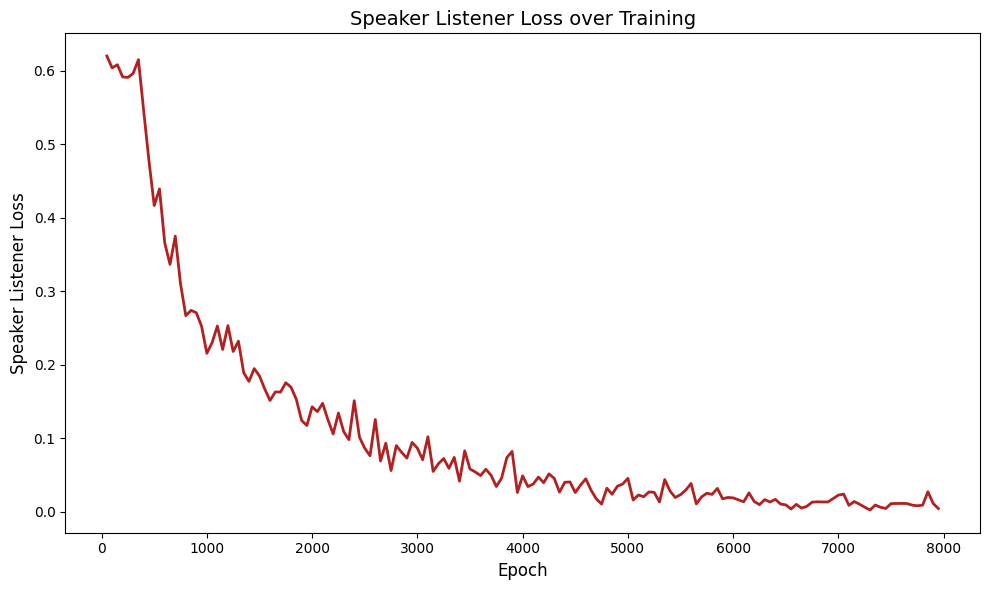

Plot saved to speaker_accuracy.png


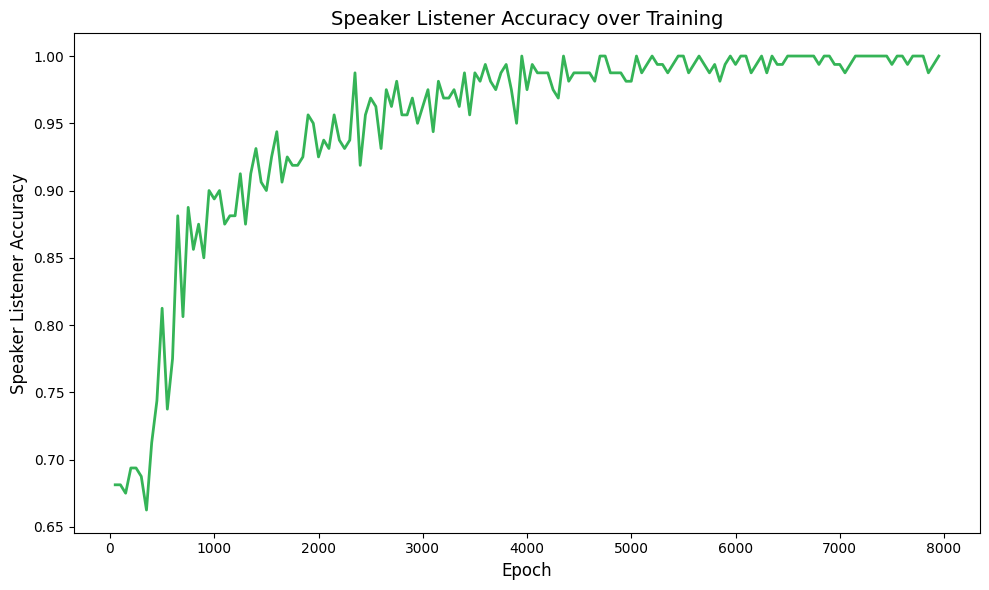

In [16]:
# Training graphs
plot_metric(losses, step_size=50, metric_name='Speaker Listener Loss', save_path='speaker_loss.png')
plot_metric(accuracies, step_size=50, metric_name='Speaker Listener Accuracy', save_path='speaker_accuracy.png')

### Inference

In [17]:
# Freeze the speaker-listener model parameters
for param in model.parameters():
    param.requires_grad = False

model.eval()

SpeakerListenerSystem(
  (encoder): ObjectEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=16, out_features=6, bias=True)
    )
  )
  (speaker): Speaker(
    (speaker_net): Sequential(
      (0): Linear(in_features=35, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=12, bias=True)
    )
  )
  (listener): Listener(
    (listener_net): Sequential(
      (0): Linear(in_features=18, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=1, bias=True)
    )
  )
)

In [18]:
print("\n--- Running a test example ---")

with torch.no_grad():
    W_test, X_test_mask = dataset_splits['speaker_listener']['W'][0:1], dataset_splits['speaker_listener']['X_mask'][0:1]

    # dummy data
    # generate_batch(1, WORLD_SIZE)
    
    print("Test World W has 5 objects.")
    print(f"Target set X is selected by mask: {X_test_mask[0]}")
    
    
    y_test_logits, y_test_labels = model(W_test, X_test_mask)
    y_test_probs  = torch.sigmoid(y_test_logits)

    print(f"Ground truth vector: {y_test_labels.numpy().flatten()}")
    
    print(f"Model prediction (probabilities): {y_test_probs.numpy().flatten()}")
    print(f"Final prediction (rounded): {[round(p, 2) for p in y_test_probs.numpy().flatten()]}")


--- Running a test example ---
Test World W has 5 objects.
Target set X is selected by mask: tensor([0., 1., 1., 1., 1.])
Ground truth vector: [1. 0. 1. 1. 1.]
Model prediction (probabilities): [1.000000e+00 9.570977e-12 9.982387e-01 1.000000e+00 9.999974e-01]
Final prediction (rounded): [np.float32(1.0), np.float32(0.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]


In [19]:
# Evaluate speaker-listener on full test set
print("\n--- Evaluating speaker-listener on full test set ---")

test_losses = []
test_accuracies = []

N_TEST = len(dataset_splits['translator_test']['W'])
start_index = 0

with torch.no_grad():  # Important: no gradients during eval
    while start_index < N_TEST:
        batch_size = min(BATCH_SIZE, N_TEST - start_index)
        
        # Load test batch
        W_batch, X_mask_batch = load_batch(
            'translator_test', start_index, batch_size
        )
            
        # Predict
        test_logits, test_truth = model(W_batch, X_mask_batch)
        
        # Calculate loss
        loss = criterion(test_logits, test_truth)

         # Calculate accuracy for monitoring
        preds    = torch.sigmoid(test_logits) > 0.5
        accuracy = (preds.float() == test_truth).float().mean() 
        
        # Store metrics
        test_losses.append(loss.item())
        test_accuracies.append(accuracy.item())
        
        start_index += batch_size

# Print overall results
print(f"Test Loss: {np.mean(test_losses):.4f}")
print(f"Test Accuracy: {np.mean(test_accuracies):.4f}")



--- Evaluating speaker-listener on full test set ---
Test Loss: 0.0063
Test Accuracy: 0.9993


### Validation
We want to check that the speaker learns the actual features of the subset with respect to the larger world, instead of some cheat like the mask positions.
We do this by testing whether the neuralese representing similar rules are closer in distance than different rules.

In [51]:
# Add features to object matrix
def add_color(matrix, color):
    if color == 'red':
        matrix[0, 0] = 1
    elif color == 'green':
        matrix[0, 1] = 1
    elif color == 'purple':
        matrix[0, 2] = 1
    return matrix

def add_shape(matrix, shape):
    if shape == 'circle':
        matrix[1, 0] = 1
    elif shape == 'square':
        matrix[1, 1] = 1
    elif shape == 'triangle':
        matrix[1, 2] = 1
    return matrix

def add_outline(matrix, outline):
    if outline == 'none':
        matrix[2, 0] = 1
    elif outline == 'thin':
        matrix[2, 1] = 1
    elif outline == 'thick':
        matrix[2, 2] = 1
    return matrix

# Create a world with specific objects

# Red Circle No Outline
O_1a = [np.zeros((3,3))] 
O_1a = add_color(O_1a[0], 'red')
O_1a = add_shape(O_1a, 'circle')
O_1a = add_outline(O_1a, 'none')

# Green Circle Thick Outline
O_1b = [np.zeros((3,3))]
O_1b = add_color(O_1b[0], 'green')
O_1b = add_shape(O_1b, 'circle')
O_1b = add_outline(O_1b, 'thick')

# Red Square Thin Outline
O_1c = [np.zeros((3,3))]
O_1c = add_color(O_1c[0], 'red')
O_1c = add_shape(O_1c, 'square')
O_1c = add_outline(O_1c, 'thin')

# Purple Triangle No Outline
O_1d = [np.zeros((3,3))]
O_1d = add_color(O_1d[0], 'purple')
O_1d = add_shape(O_1d, 'triangle')
O_1d = add_outline(O_1d, 'none')

# Green Square Thin Outline
O_1e = [np.zeros((3,3))]
O_1e = add_color(O_1e[0], 'green')
O_1e = add_shape(O_1e, 'square')
O_1e = add_outline(O_1e, 'thin')

## Create another world with different objects

# Purple Circle No Outline
O_2a = [np.zeros((3,3))]
O_2a = add_color(O_2a[0], 'purple')
O_2a = add_shape(O_2a, 'circle')
O_2a = add_outline(O_2a, 'none')

# Green Triangle No Outline
O_2b = [np.zeros((3,3))] 
O_2b = add_color(O_2b[0], 'green')
O_2b = add_shape(O_2b, 'triangle')
O_2b = add_outline(O_2b, 'none')

# Purple Square Thick Outline
O_2c = [np.zeros((3,3))]    
O_2c = add_color(O_2c[0], 'purple')
O_2c = add_shape(O_2c, 'square')
O_2c = add_outline(O_2c, 'thick')

# Red Triangle Thin Outline
O_2d = [np.zeros((3,3))]
O_2d = add_color(O_2d[0], 'red')
O_2d = add_shape(O_2d, 'triangle')
O_2d = add_outline(O_2d, 'thin')

# Red Circle Thick Outline
O_2e = [np.zeros((3,3))]
O_2e = add_color(O_2e[0], 'red')
O_2e = add_shape(O_2e, 'circle')
O_2e = add_outline(O_2e, 'thick')

W_1 = torch.tensor([O_1a, O_1b, O_1c, O_1d, O_1e]).float().unsqueeze(0)  # (1, 5, 3, 3)
W_2 = torch.tensor([O_2a, O_2b, O_2c, O_2d, O_2e]).float().unsqueeze(0)  # (1, 5, 3, 3)

X_1_red = torch.tensor([[1, 0, 1, 0, 0]]).float()  # red
X_2_red = torch.tensor([[0, 0, 0, 1, 1]]).float()  # red

X_1_not_thick = torch.tensor([[0, 1, 0, 0, 1]]).float()  # green
X_2_not_thick = torch.tensor([[0, 1, 0, 0, 0]]).float()  # green




In [52]:
V_1_red = model(W_1, X_1_red, return_neuralese_only=True)
V_2_red = model(W_2, X_2_red, return_neuralese_only=True)

V_1_not_thick = model(W_1, X_1_not_thick, return_neuralese_only=True)
V_2_not_thick = model(W_2, X_2_not_thick, return_neuralese_only=True)

print(f"red vector 1: {V_1_red}")
print(f"red vector 2: {V_2_red}")

print(f"not thick vector 1: {V_1_not_thick}")
print(f"not thick vector 2: {V_2_not_thick}")

red vector 1: tensor([[-17.4443,  -3.5998,  13.9510,  -3.8726,  21.0706,  -1.1440,  -7.2438,
          19.6447,  26.7556,  -7.5627, -29.4003, -18.1397]])
red vector 2: tensor([[-11.2324,  -4.2298,  14.9127,   1.7453,   7.5796,   5.3130,  -8.2778,
           9.0345,   8.7105,  -3.4749, -16.0186, -17.0215]])
not thick vector 1: tensor([[-14.2484,  -1.3802,  19.4741,  -3.2413,  21.7441,   1.4562,  -3.4284,
          20.4543,  27.0839,  -5.2883, -27.9799, -16.2712]])
not thick vector 2: tensor([[-11.8325,  -5.9331,  13.0554,   0.4777,   6.6955,   4.3779, -10.2294,
           7.4635,   9.4873,  -4.9321, -17.8207, -18.2351]])


In [53]:
sim_same_1 = F.cosine_similarity(V_1_red, V_2_red, dim=1).item()
sim_same_2 = F.cosine_similarity(V_1_not_thick, V_2_not_thick, dim=1).item()

sim_diff_1 = F.cosine_similarity(V_1_red, V_1_not_thick, dim=1).item()
sim_diff_2 = F.cosine_similarity(V_2_red, V_2_not_thick, dim=1).item()
sim_diff_3 = F.cosine_similarity(V_1_red, V_2_not_thick, dim=1).item()
sim_diff_4 = F.cosine_similarity(V_2_red, V_1_not_thick, dim=1).item()

print(f"Similar distances: {sim_same_1}, {sim_same_2}")
print(f"Farther distances: {sim_diff_1}, {sim_diff_2}, {sim_diff_3}, {sim_diff_4}")

Similar distances: 0.9005727171897888, 0.8791633248329163
Farther distances: 0.9881964921951294, 0.9914703369140625, 0.8999921083450317, 0.8965859413146973


## The Translator

### Prepare Translator Data

In [20]:
# map vocabulary to tokens
VOCABULARY = {
    '<blank>'      : 0,
    'not'          : 1,
    'and'          : 2,
    'or'           : 3,
    'red'          : 4,
    'green'        : 5,
    'purple'       : 6,
    'circle'       : 7,
    'square'       : 8,
    'triangle'     : 9,
    'no-outline'   : 10,
    'slim-outline' : 11,
    'thick-outline': 12
}
IDX_TO_TOKEN = {v: k for k, v in VOCABULARY.items()}

In [21]:
# Convert rules to token sequences
def rule_text_to_tokens(rule_text, max_rule_length=3):
    """
    Convert rule text string into a fixed-length sequence of tokens.

    Arguments:
        rule_text: String representation of the rule (e.g., "red and circle")
        max_rule_length: Fixed sequence length (default 3)

    Returns:
        List of token indices representing the rule, padded with <blank> tokens.
    """
    tokens = rule_text.split()
    token_indices = [VOCABULARY[token] for token in tokens]

    # Pad with <blank> tokens if necessary
    while len(token_indices) < max_rule_length:
        token_indices.append(VOCABULARY['<blank>'])

    return token_indices[:max_rule_length]


train_rule_tokens = [
    rule_text_to_tokens(rule_text) 
    for rule_text in dataset_splits['translator_train']['rule_texts']
]

test_rule_tokens = [
    rule_text_to_tokens(rule_text) 
    for rule_text in dataset_splits['translator_test']['rule_texts']
]
train_targets = torch.tensor(train_rule_tokens, dtype=torch.long)
test_targets  = torch.tensor(test_rule_tokens, dtype=torch.long)

# Add tokenized rules to dataset splits
dataset_splits['translator_train']['rule_tokens'] = train_targets
dataset_splits['translator_test']['rule_tokens']  = test_targets

# Print shapes and examples
print(f"Train targets shape: {train_targets.shape}")
print(f"Test targets shape : {test_targets.shape}")
print(f"\nFirst 5 train examples:")
for i in range(5):
    rule_text = dataset_splits['translator_train']['rule_texts'][i]
    tokens = train_targets[i].tolist()
    decoded = [IDX_TO_TOKEN[t] for t in tokens]
    print(f"  '{rule_text}' -> {tokens} -> {decoded}")


Train targets shape: torch.Size([682333, 3])
Test targets shape : torch.Size([170584, 3])

First 5 train examples:
  'green and triangle' -> [5, 2, 9] -> ['green', 'and', 'triangle']
  'not square' -> [1, 8, 0] -> ['not', 'square', '<blank>']
  'purple or square' -> [6, 3, 8] -> ['purple', 'or', 'square']
  'triangle or slim-outline' -> [9, 3, 11] -> ['triangle', 'or', 'slim-outline']
  'circle' -> [7, 0, 0] -> ['circle', '<blank>', '<blank>']


### Training

In [ ]:
# Hyperparameters for training
BATCH_SIZE    = 32 # 32
NUM_EPOCHS    = 15 # 2000
LEARNING_RATE = 1e-4

In [32]:
# Initialize the translator model
translator_model = Translator(
    neuralese_dimension = NEURALESE_DIMENSION,
    max_rule_length     = 3,
    vocab_size          = len(VOCABULARY),
    hidden_dimension    = 128
)

translator_optimizer = optim.Adam(translator_model.parameters(), lr=LEARNING_RATE)
translator_criterion = nn.CrossEntropyLoss()

In [33]:
# Training loop
step = 0
start_index = 0
N_DATA = len(dataset_splits['translator_train']['W'])

losses = []
token_accuracies = []
sequence_accuracies = []

print("Starting translator training...")
for epoch in range(NUM_EPOCHS):
    start_index = 0

    # Stop when we run out of data
    while start_index < N_DATA:
        batch_size = min(BATCH_SIZE, N_DATA - start_index)

        # Load a batch of translator training data
        W_batch, X_mask_batch, rule_tokens_batch = load_batch(
            'translator_train', start_index, batch_size, include_rules=True
        )
        start_index += BATCH_SIZE
        step += 1

        # Get the neuralese representations from the frozen speaker
        with torch.no_grad():
            # (batch_size, neuralese_dimension)
            V_batch = model(W_batch, X_mask_batch, return_neuralese_only=True)

        # Predict the rule tokens
        # (batch_size, max_rule_length, vocab_size)
        translator_optimizer.zero_grad()
        predicted_logits = translator_model(V_batch) 

        # Calculate loss for each position in the rule
        loss = translator_criterion(
            predicted_logits.view(-1, len(VOCABULARY)),  # (batch_size * max_rule_length, vocab_size)
            rule_tokens_batch.view(-1)                   # (batch_size * max_rule_length,)
        )

        # Optimize
        loss.backward()
        translator_optimizer.step()

        if (step + 1) % 500 == 0:
            # Track data consumption
            print(f"Epoch: {epoch}. start_index: {start_index}, end_index: {start_index + batch_size}")

            # Calculate token-level accuracy
            predicted_tokens = torch.argmax(predicted_logits, dim=2)  # (batch_size, max_rule_length)
            correct_tokens   = (predicted_tokens == rule_tokens_batch).float()
            token_accuracy   = correct_tokens.mean().item()

            # Calculate sequence-level accuracy
            sequence_correct = (correct_tokens.sum(dim=1) == correct_tokens.shape[1]).float()
            sequence_accuracy = sequence_correct.mean().item()

            print(f"Step [{step+1}/---], Loss: {loss.item():.4f}, Token Acc: {token_accuracy:.4f}, Seq Acc: {sequence_accuracy:.4f}")

            # Store metrics
            losses.append(loss.item())
            token_accuracies.append(token_accuracy)
            sequence_accuracies.append(sequence_accuracy)

print("Translator training finished.")


Starting translator training...
Epoch: 0. start_index: 15968, end_index: 16000
Step [500/---], Loss: 1.7899, Token Acc: 0.4375, Seq Acc: 0.0312
Epoch: 0. start_index: 31968, end_index: 32000
Step [1000/---], Loss: 1.6819, Token Acc: 0.4375, Seq Acc: 0.0625
Epoch: 0. start_index: 47968, end_index: 48000
Step [1500/---], Loss: 1.6666, Token Acc: 0.4583, Seq Acc: 0.0312
Epoch: 0. start_index: 63968, end_index: 64000
Step [2000/---], Loss: 1.4744, Token Acc: 0.5417, Seq Acc: 0.1250
Epoch: 0. start_index: 79968, end_index: 80000
Step [2500/---], Loss: 1.5761, Token Acc: 0.5312, Seq Acc: 0.1875
Epoch: 0. start_index: 95968, end_index: 96000
Step [3000/---], Loss: 1.5328, Token Acc: 0.5000, Seq Acc: 0.1250
Epoch: 0. start_index: 111968, end_index: 112000
Step [3500/---], Loss: 1.5893, Token Acc: 0.4792, Seq Acc: 0.0938
Epoch: 0. start_index: 127968, end_index: 128000
Step [4000/---], Loss: 1.7133, Token Acc: 0.4271, Seq Acc: 0.0625
Epoch: 0. start_index: 143968, end_index: 144000
Step [4500/-

Plot saved to translator_loss.png


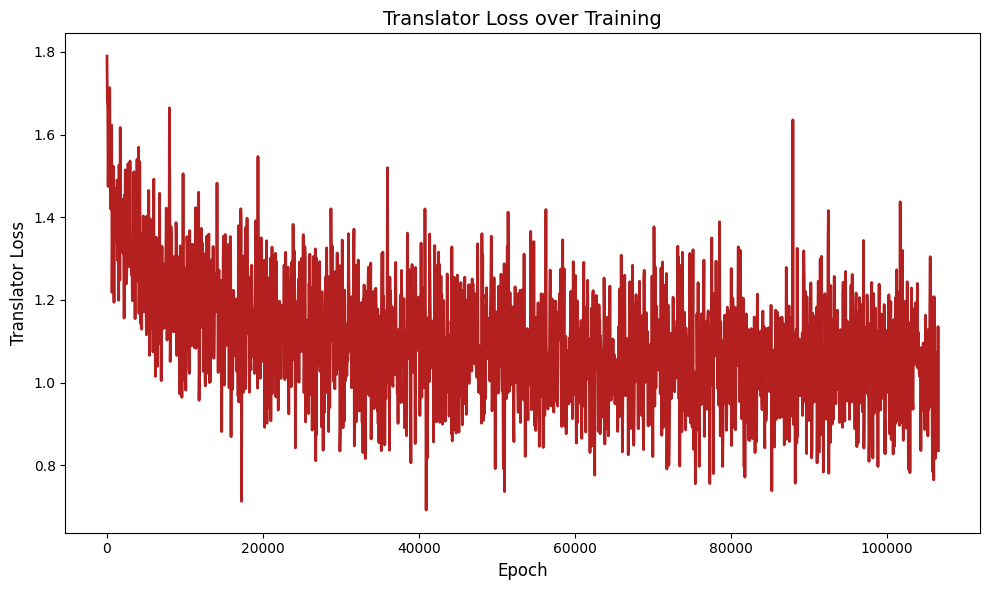

Plot saved to translator_token_accuracy.png


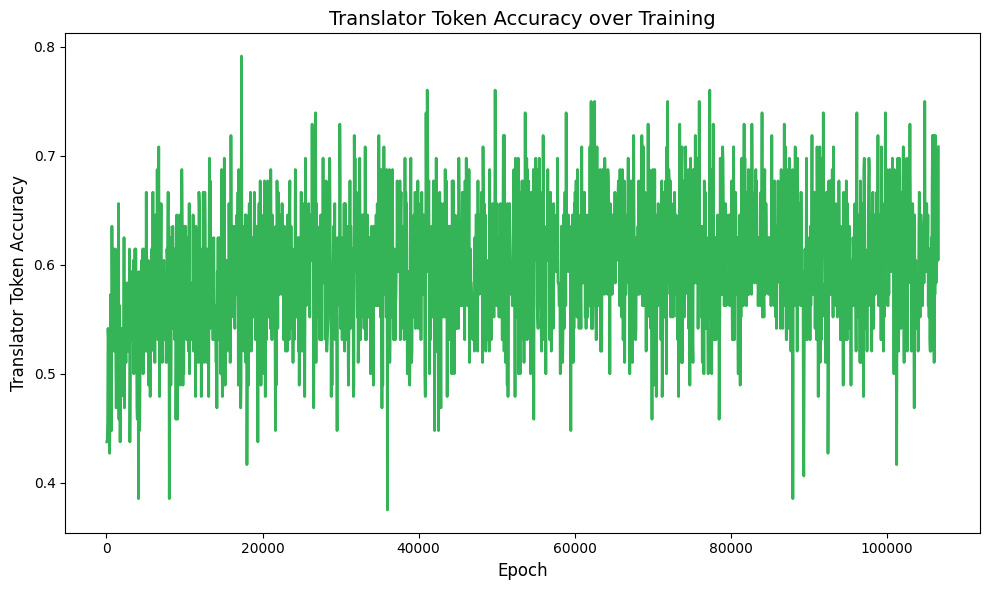

Plot saved to translator_sequence_accuracy.png


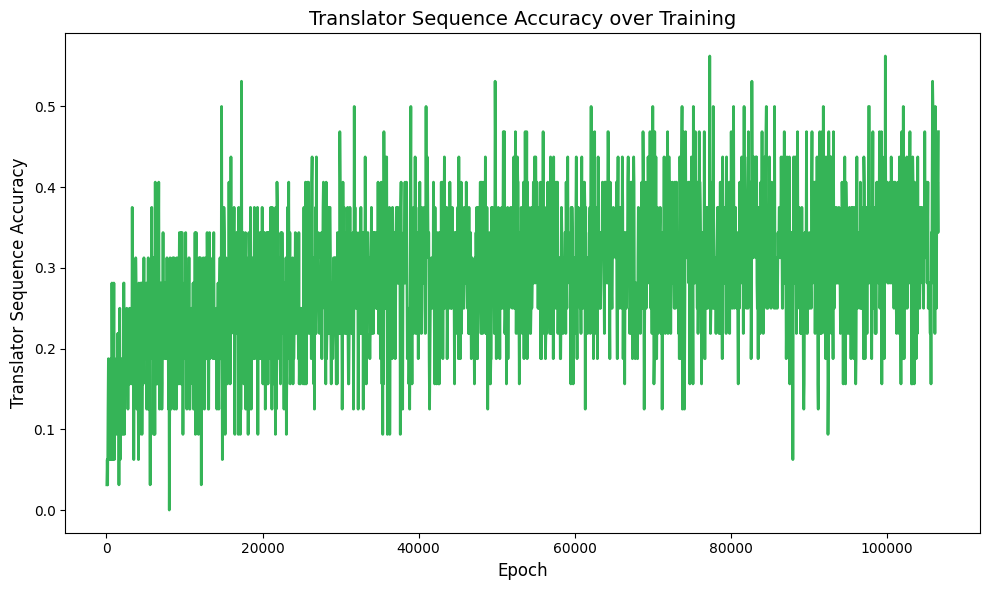

In [35]:
# Training graphs
plot_metric(losses, step_size=50, metric_name='Translator Loss', save_path='translator_loss.png')
plot_metric(token_accuracies, step_size=50, metric_name='Translator Token Accuracy', save_path='translator_token_accuracy.png')
plot_metric(sequence_accuracies, step_size=50, metric_name='Translator Sequence Accuracy', save_path='translator_sequence_accuracy.png')

### Inference

In [36]:
# Freeze translator model parameters
for param in translator_model.parameters():
    param.requires_grad = False 

translator_model.eval()

Translator(
  (translation_net): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=39, bias=True)
  )
)

In [58]:
# Run a test example
print("\n--- Running a translator test example ---")

with torch.no_grad():
    W_test, X_test_mask, rule_test_tokens = load_batch(
        'translator_test', 204, 205, include_rules=True
    )

    print("Test World W has 5 objects.")
    print(f"Target set X is selected by mask: {X_test_mask[0]}")
    print(f"Ground truth rule tokens: {rule_test_tokens[0].tolist()}")

    # Get neuralese representation from the frozen speaker
    V_test = model(W_test, X_test_mask, return_neuralese_only=True)

    # Predict the rule tokens
    predicted_logits = translator_model(V_test)  # (1, max_rule_length, vocab_size)
    predicted_tokens = torch.argmax(predicted_logits, dim=2)  # (1, max_rule_length)

    print(f"Predicted rule tokens: {predicted_tokens[0].tolist()}")

    # Decode tokens to text
    decoded_predicted = [IDX_TO_TOKEN[t.item()] for t in predicted_tokens[0]]
    decoded_ground_truth = [IDX_TO_TOKEN[t.item()] for t in rule_test_tokens[0]]

    print(f"Decoded predicted rule: {decoded_predicted}")
    print(f"Decoded ground truth rule: {decoded_ground_truth}")


--- Running a translator test example ---
Test World W has 5 objects.
Target set X is selected by mask: tensor([0., 0., 0., 1., 1.])
Ground truth rule tokens: [9, 0, 0]
Predicted rule tokens: [6, 0, 9]
Decoded predicted rule: ['purple', '<blank>', 'triangle']
Decoded ground truth rule: ['triangle', '<blank>', '<blank>']


In [41]:
# Evaluate translator on full test set
print("\n--- Evaluating translator on full test set ---")
translator_model.eval()

test_losses = []
test_token_accs = []
test_seq_accs = []

N_TEST = len(dataset_splits['translator_test']['W'])
start_index = 0

with torch.no_grad():  # Important: no gradients during eval
    while start_index < N_TEST:
        batch_size = min(BATCH_SIZE, N_TEST - start_index)
        
        # Load test batch
        W_batch, X_mask_batch, rule_tokens_batch = load_batch(
            'translator_test', start_index, batch_size, include_rules=True
        )
        
        # Get neuralese from frozen speaker
        V_batch = model(W_batch, X_mask_batch, return_neuralese_only=True)
        
        # Predict
        predicted_logits = translator_model(V_batch)
        
        # Calculate loss
        loss = translator_criterion(
            predicted_logits.view(-1, len(VOCABULARY)),
            rule_tokens_batch.view(-1)
        )
        
        # Calculate accuracies
        predicted_tokens = torch.argmax(predicted_logits, dim=2)
        correct_tokens = (predicted_tokens == rule_tokens_batch).float()
        token_acc = correct_tokens.mean().item()
        seq_acc = (correct_tokens.sum(dim=1) == 3).float().mean().item()
        
        # Store metrics
        test_losses.append(loss.item())
        test_token_accs.append(token_acc)
        test_seq_accs.append(seq_acc)
        
        start_index += batch_size

# Print overall results
print(f"Test Loss: {np.mean(test_losses):.4f}")
print(f"Test Token Accuracy: {np.mean(test_token_accs):.4f}")
print(f"Test Sequence Accuracy: {np.mean(test_seq_accs):.4f}")


--- Evaluating translator on full test set ---
Test Loss: 0.9192
Test Token Accuracy: 0.6530
Test Sequence Accuracy: 0.3975
